In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('../data/ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [3]:
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes                # new_user_id = userId - 1

In [4]:
df.tail()

,userId,movieId,rating,timestamp,new_user_id
20000258,138493,68954,4.5,1258126920,138492
20000259,138493,69526,4.5,1259865108,138492
20000260,138493,69644,3.0,1260209457,138492
20000261,138493,70286,5.0,1258126944,138492
20000262,138493,71619,2.5,1255811136,138492


In [5]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes    # coded new_movie_id by order start from zero

In [6]:
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49


In [7]:
# Get user IDs, movie IDs and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5     # Scaling of rating

In [8]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimemsion
D = 10

In [9]:
# Make a neural network
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim

    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2*self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)

    # set the weights since N(0,1) leads to poor results      
    # Manually hyperparameter initialization with weights --> Cuda 사용율 3배 증가
    self.u_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
    self.m_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.M, self.D) * 0.01))

  def forward(self, u, m):
    u = self.u_emb(u)  # output is (num_samples, D)
    m = self.m_emb(m)  # output is (num_samples, D)

    # merge
    out = torch.cat((u,m),1)   # output is (num_samples, 2D)

    # ANN
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [13]:
# A function to encapsulate the training loop
def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # batches per epoch
  Ntrain = len(train_users)
  batches_per_epoch = int(np.ceil(Ntrain/bs))

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []

    # shuffle each batch
    train_users, train_movies, train_ratings = shuffle(
        train_users, train_movies, train_ratings
    )

    for j in range(batches_per_epoch):
      # get the batch
      users = train_users[j*bs:(j+1)*bs]
      movies = train_movies[j*bs:(j+1)*bs]
      targets = train_ratings[j*bs:(j+1)*bs]

      # convert to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)

      # reshape targets
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)
      
      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      
    # Get train loss and test loss
    train_loss = np.mean(train_loss)   # a little misleading

    # we could do this if the test set size was manageable
    # test_outputs = model(test_users, test_movies)
    # test_loss = criterion(test_outputs, test_ratings).item()
    test_loss = []
    for j in range(int(np.ceil(len(test_users) / bs))):
      # get the batch
      users = test_users[j*bs:(j+1)*bs]
      movies = test_movies[j*bs:(j+1)*bs]
      targets = test_ratings[j*bs:(j+1)*bs]

      # convert to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)

      # reshape targets
      targets = targets.view(-1,1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)
      
      outputs = model(users, movies)
      loss = criterion(outputs, targets).item()
      test_loss.append(loss)
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0      
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [14]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [15]:
# Make datasets
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd2(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    10)

Epoch 1/10, Train Loss: 0.7261, Test Loss: 0.6840, Duration: 0:01:11.482313
Epoch 2/10, Train Loss: 0.6545, Test Loss: 0.6517, Duration: 0:01:11.800406
Epoch 3/10, Train Loss: 0.6174, Test Loss: 0.6392, Duration: 0:01:10.995645
Epoch 4/10, Train Loss: 0.5962, Test Loss: 0.6320, Duration: 0:01:11.104291
Epoch 5/10, Train Loss: 0.5828, Test Loss: 0.6292, Duration: 0:01:11.230616
Epoch 6/10, Train Loss: 0.5736, Test Loss: 0.6274, Duration: 0:01:11.528570
Epoch 7/10, Train Loss: 0.5669, Test Loss: 0.6266, Duration: 0:01:10.715920
Epoch 8/10, Train Loss: 0.5617, Test Loss: 0.6256, Duration: 0:01:10.904205
Epoch 9/10, Train Loss: 0.5575, Test Loss: 0.6256, Duration: 0:01:10.386484
Epoch 10/10, Train Loss: 0.5541, Test Loss: 0.6268, Duration: 0:01:10.582934


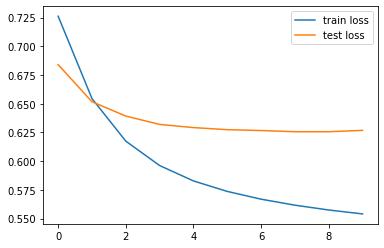

In [16]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [17]:
# Suppose I want to find recommendations for user_id = 1
# First find all the movie_ids for movies they haven't yet watched
watched_movie_ids = df[df.new_user_id == 1].new_movie_id.values

In [18]:
watched_movie_ids

array([   2,   61,   69,  108,  239,  257,  263,  465,  476,  537,  583,
        874,  891,  907, 1098, 1171, 1184, 1188, 1221, 1231, 1242, 1298,
       1326, 1494, 1528, 1616, 1684, 1881, 1885, 1886, 1887, 1888, 1889,
       1890, 1902, 2206, 2369, 2370, 2705, 2772, 2862, 2865, 3063, 3072,
       3086, 3361, 3423, 3443, 3464, 3474, 3612, 3662, 3824, 3825, 3830,
       3833, 3834, 3835, 3837, 3843, 3865], dtype=int16)

In [44]:
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()

In [45]:
# How many?
potential_movie_ids.shape

(26683,)

In [46]:
len(set(potential_movie_ids))

26683

In [47]:
# Repeat the user id this many times --> the same aray but replace to only add 1
user_id_to_recommend = np.ones_like(potential_movie_ids)

In [48]:
# Convert to torch tensor
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

In [49]:
# Get predictions
with torch.no_grad():
    predictions = model(t_user_ids, t_movie_ids)

In [50]:
# Convert predictions to Numpy
predictions_np = predictions.cpu().numpy().flatten()

In [51]:
predictions_np

array([1.3654692, 1.5292335, 1.8449266, ..., 1.3355634, 1.19651  ,
       1.334086 ], dtype=float32)

In [52]:
# Get sort index for predictions
sort_idx = np.argsort(-predictions_np)   # - : means inverse sorting

In [53]:
sort_idx

array([ 6267,  8145,  6762, ..., 13520,  6742, 11793], dtype=int64)

In [54]:
# Top 10 predictions
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
    print("movie:", movie, "score:", score) 

movie: 8552 score: 2.6488743
movie: 6401 score: 2.645079
movie: 9919 score: 2.6121867
movie: 25070 score: 2.5506587
movie: 7041 score: 2.542558
movie: 12668 score: 2.533606
movie: 5853 score: 2.4961967
movie: 6417 score: 2.4955423
movie: 7488 score: 2.4883852
movie: 7498 score: 2.4852087
